## ``Causal_sampler`` Demo. 03: 

### Simulation on the synthetic classification task for a general causal graph

> Front-door confounding

In this demonstration, we demonstrate a deconfounding showcase with a more general causal graph (ADMG) that cannot be considered as either a backdoor or front-door confounding scenario. 

Here, $Y$ is the cause and $X$ is the effect.

In [1]:
import causal_sampler.pipeline as cs_pipe
from sklearn.metrics import classification_report
from sklearn import svm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import math

plt.rcParams['font.family'] = 'Calibri'
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["axes.titlesize"] = 16

testdata_dir = r"../test_data/synthetic_data/complex_scenario/"

In [2]:
def _plane_z_from_linear_clf(clf, X, Y, axis=2, eps=1e-12):
    w = np.asarray(clf.coef_[0], float)
    b = float(clf.intercept_[0])
    denom = w[axis]
    if abs(denom) < eps:
        raise ValueError("z cannot be computed because the coefficient for the specified axis is too small")
    return -(b + w[0]*X + w[1]*Y) / denom

def plot_decision_boundaries_grid(
    conf_clf,
    deconf_clfs,             
    X_test_unconf, Y_test_unconf,
    *,
    n_row=None, n_col=None,   
    xy_lim=(-6, 6),
    grid_n=50, aux_n=20,
    alpha_surface=0.5,
    figsize_per_ax=(5, 5)
):

    M = len(deconf_clfs)
    if M == 0:
        raise ValueError("deconf_clfs cannot be empty")

    if n_row is None and n_col is None:
        n_col = int(math.ceil(math.sqrt(M)))
        n_row = int(math.ceil(M / n_col))
    elif n_row is None:
        n_row = int(math.ceil(M / int(n_col)))
    elif n_col is None:
        n_col = int(math.ceil(M / int(n_row)))
    n_row, n_col = int(n_row), int(n_col)

    if n_row * n_col < M:
        raise ValueError(f"{n_row}x{n_col}<{M}")

    x = np.linspace(*xy_lim, grid_n)
    y = np.linspace(*xy_lim, grid_n)
    xx1, xx2 = np.meshgrid(x, y)

    conf_x2, conf_x3 = np.meshgrid(np.linspace(*xy_lim, aux_n), np.linspace(*xy_lim, aux_n))
    conf_x1 = np.zeros_like(conf_x2)

    real_x1, real_x2 = np.meshgrid(np.linspace(*xy_lim, aux_n), np.linspace(*xy_lim, aux_n))
    real_x3 = np.zeros_like(real_x1)

    xx_conf = _plane_z_from_linear_clf(conf_clf, xx1, xx2, axis=2)

    fig = plt.figure(figsize=(figsize_per_ax[0]*n_col, figsize_per_ax[1]*n_row))
    for idx, (title, deconf_clf) in enumerate(deconf_clfs):
        r = idx // n_col
        c = idx % n_col
        ax = fig.add_subplot(n_row, n_col, idx+1, projection='3d')

        ax.scatter3D(X_test_unconf[:, 0], X_test_unconf[:, 1], X_test_unconf[:, 2],
                     c=Y_test_unconf, s=5, alpha=0.5)

        ax.plot_surface(conf_x1, conf_x2, conf_x3, alpha=alpha_surface, rstride=100, cstride=100, color="yellow")
        ax.plot_surface(real_x1, real_x2, real_x3, alpha=alpha_surface, rstride=100, cstride=100, color="green")
        ax.plot_surface(xx1, xx2, xx_conf,    alpha=alpha_surface, rstride=100, cstride=100, color="red")

        xx_deconf = _plane_z_from_linear_clf(deconf_clf, xx1, xx2, axis=2)
        ax.plot_surface(xx1, xx2, xx_deconf, alpha=alpha_surface, rstride=100, cstride=100, color="blue")

        ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3')
        ax.set_xlim(*xy_lim); ax.set_ylim(*xy_lim); ax.set_zlim(*xy_lim)
        ax.set_title(title)

    legend_elems = [
        Line2D([0], [0], marker='o', linestyle='None', markersize=6, alpha=0.5, label='Unconfounded test data'),
        Patch(facecolor="yellow", alpha=alpha_surface, label="confounding boundary (x1=0)"),
        Patch(facecolor="green",  alpha=alpha_surface, label="real boundary (x3=0)"),
        Patch(facecolor="red",    alpha=alpha_surface, label="confounded decision boundary"),
        Patch(facecolor="blue",   alpha=alpha_surface, label="deconfounded decision boundary"),
    ]
    fig.legend(handles=legend_elems, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

0. Define the causal graph

In [3]:
causal_graph = '"General Causal Graph"; \
                Y; X; U; Z; \
                U -> Y; \
                Y -> Z; \
                U -> Z; \
                Z -> X; \
                X <-> Y;'

1. Load datasets

In [4]:
X_train_conf = pd.read_csv(testdata_dir + "X_train_conf.csv").values
Y_train_conf = pd.read_csv(testdata_dir + "Y_train_conf.csv").values
Z_train_conf = pd.read_csv(testdata_dir + "Z_train_conf.csv").values
U_train_conf = pd.read_csv(testdata_dir + "U_train_conf.csv").values

X_test_unconf = pd.read_csv(testdata_dir + "X_test_unconf.csv").values
Y_test_unconf = pd.read_csv(testdata_dir + "Y_test_unconf.csv").values

X_test_conf = pd.read_csv(testdata_dir + "X_test_conf.csv").values
Y_test_conf = pd.read_csv(testdata_dir + "Y_test_conf.csv").values

2. Assign the key-value pair for each variable and prepare essential parameters

In [5]:
conf_train_data = {"Y'": Y_train_conf,
                   "X": X_train_conf,
                   "Z": Z_train_conf,
                   "U": U_train_conf}
n_bins = {"U":[0], 
          "Y'":[0], 
          "Z":[0, 0], 
          "X":[0, 0, 0]}
intv_values = np.unique(Y_train_conf)
n_samples = 2000

3. Initialize a CW-GMM based deconfounding pipeline and fit a deconfounded liner Support Vector Classifier (SVC).

In [6]:
cwgmm_flow = cs_pipe.CausalGMMSampler(causal_graph=causal_graph,
                                      cause_var_name="Y",
                                      effect_var_name="X",
                                      intv_values = np.unique(Y_train_conf),
                                      data_dict = conf_train_data,
                                      est_method = "histogram",
                                      n_bins = n_bins
                                     )

cwgmm_model = cwgmm_flow.fit(comp_k = 6,
                             return_model = True)

deconf_gmm_X, deconf_gmm_Y = cwgmm_flow.resample(n_samples = n_samples,
                                                 return_samples = True)

deconf_gmm_clf = cwgmm_flow.fit_deconf_model(ml_model = svm.SVC(kernel = 'linear', C=5))


CW-GMMs fitting:   0%|          | 0/2 [00:00<?, ?model/s]

EM iter:   0%|          | 0/1000 [00:00<?, ?it/s]

EM iter:   0%|          | 0/1000 [00:00<?, ?it/s]

4. Initialize a causal bootstrapping based deconfounding pipeline and fit a deconfounded liner SVC.

In [7]:
cb_flow = cs_pipe.CausalBootstrapSampler(causal_graph=causal_graph,
                                         cause_var_name="Y",
                                         effect_var_name="X",
                                         intv_values = np.unique(Y_train_conf),
                                         data_dict = conf_train_data,
                                         est_method = "histogram",
                                         n_bins = n_bins)
deconf_cb_X, deconf_cb_Y = cb_flow.resample(n_samples = n_samples,
                                            return_samples = True)
deconf_cb_clf = cb_flow.fit_deconf_model(ml_model = svm.SVC(kernel = 'linear', C=5))


CB Resampling:   0%|          | 0/2 [00:00<?, ?it/s]

5. Train another two linear SVCs using the original confounded dataset and the non-confounded (test) dataset.

In [8]:
nonconf_clf = svm.SVC(kernel = 'linear', C=5)
nonconf_clf = nonconf_clf.fit(X_test_unconf, Y_test_unconf.reshape(-1))

conf_clf = svm.SVC(kernel = 'linear', C=5)
conf_clf = conf_clf.fit(X_train_conf, Y_train_conf.reshape(-1))

6. compare thier performance on non-confounded and confounded test set

In [9]:
print("Test on the non-confounded test set:")

y_pred_gmm_deconf_unconf = deconf_gmm_clf.predict(X_test_unconf)
print("Report of CW-GMM based deconfounded model:")
print(classification_report(Y_test_unconf, y_pred_gmm_deconf_unconf, digits=4))
print("-"*20)
y_pred_cb_deconf_unconf = deconf_cb_clf.predict(X_test_unconf)
print("Report of CB-based deconfounded model:")
print(classification_report(Y_test_unconf, y_pred_cb_deconf_unconf, digits=4))
print("-"*20)
y_pred_unconf_unconf = nonconf_clf.predict(X_test_unconf)
print("Report of non-confounded model:")
print(classification_report(Y_test_unconf, y_pred_unconf_unconf, digits=4))
print("-"*20)
y_pred_conf_unconf = conf_clf.predict(X_test_unconf)
print("Report of confonded model:")
print(classification_report(Y_test_unconf, y_pred_conf_unconf, digits=4))

Test on the non-confounded test set:
Report of CW-GMM based deconfounded model:
              precision    recall  f1-score   support

           1     0.7249    0.7919    0.7569       865
           2     0.8294    0.7709    0.7991      1135

    accuracy                         0.7800      2000
   macro avg     0.7771    0.7814    0.7780      2000
weighted avg     0.7842    0.7800    0.7808      2000

--------------------
Report of CB-based deconfounded model:
              precision    recall  f1-score   support

           1     0.7276    0.7873    0.7562       865
           2     0.8271    0.7753    0.8004      1135

    accuracy                         0.7805      2000
   macro avg     0.7773    0.7813    0.7783      2000
weighted avg     0.7840    0.7805    0.7813      2000

--------------------
Report of non-confounded model:
              precision    recall  f1-score   support

           1     0.7407    0.7827    0.7611       865
           2     0.8269    0.7912    0.8086 

In [10]:
print("Test on the confounded test set:")

y_pred_gmm_deconf_conf = deconf_gmm_clf.predict(X_test_conf)
print("Report of deconfounded model using mechanism learning:")
print(classification_report(Y_test_conf, y_pred_gmm_deconf_conf, digits=4))
print("-"*20)
y_pred_cb_deconf_conf = deconf_cb_clf.predict(X_test_conf)
print("Report of deconfounded model using CB-based method:")
print(classification_report(Y_test_conf, y_pred_cb_deconf_conf, digits=4))
print("-"*20)
y_pred_unconf_conf = nonconf_clf.predict(X_test_conf)
print("Report of non-confounded model:")
print(classification_report(Y_test_conf, y_pred_unconf_conf, digits=4))
print("-"*20)
y_pred_conf_conf = conf_clf.predict(X_test_conf)
print("Report of confounded model:")
print(classification_report(Y_test_conf, y_pred_conf_conf, digits=4))

Test on the confounded test set:
Report of deconfounded model using mechanism learning:
              precision    recall  f1-score   support

           1     0.9227    0.7944    0.8537      1532
           2     0.5374    0.7821    0.6371       468

    accuracy                         0.7915      2000
   macro avg     0.7301    0.7882    0.7454      2000
weighted avg     0.8325    0.7915    0.8030      2000

--------------------
Report of deconfounded model using CB-based method:
              precision    recall  f1-score   support

           1     0.9251    0.7977    0.8566      1532
           2     0.5434    0.7885    0.6434       468

    accuracy                         0.7955      2000
   macro avg     0.7343    0.7931    0.7500      2000
weighted avg     0.8358    0.7955    0.8067      2000

--------------------
Report of non-confounded model:
              precision    recall  f1-score   support

           1     0.9281    0.7833    0.8496      1532
           2     0.5304

7. Draw the decision boundaries for the four SVCs and datasets in 3D plot

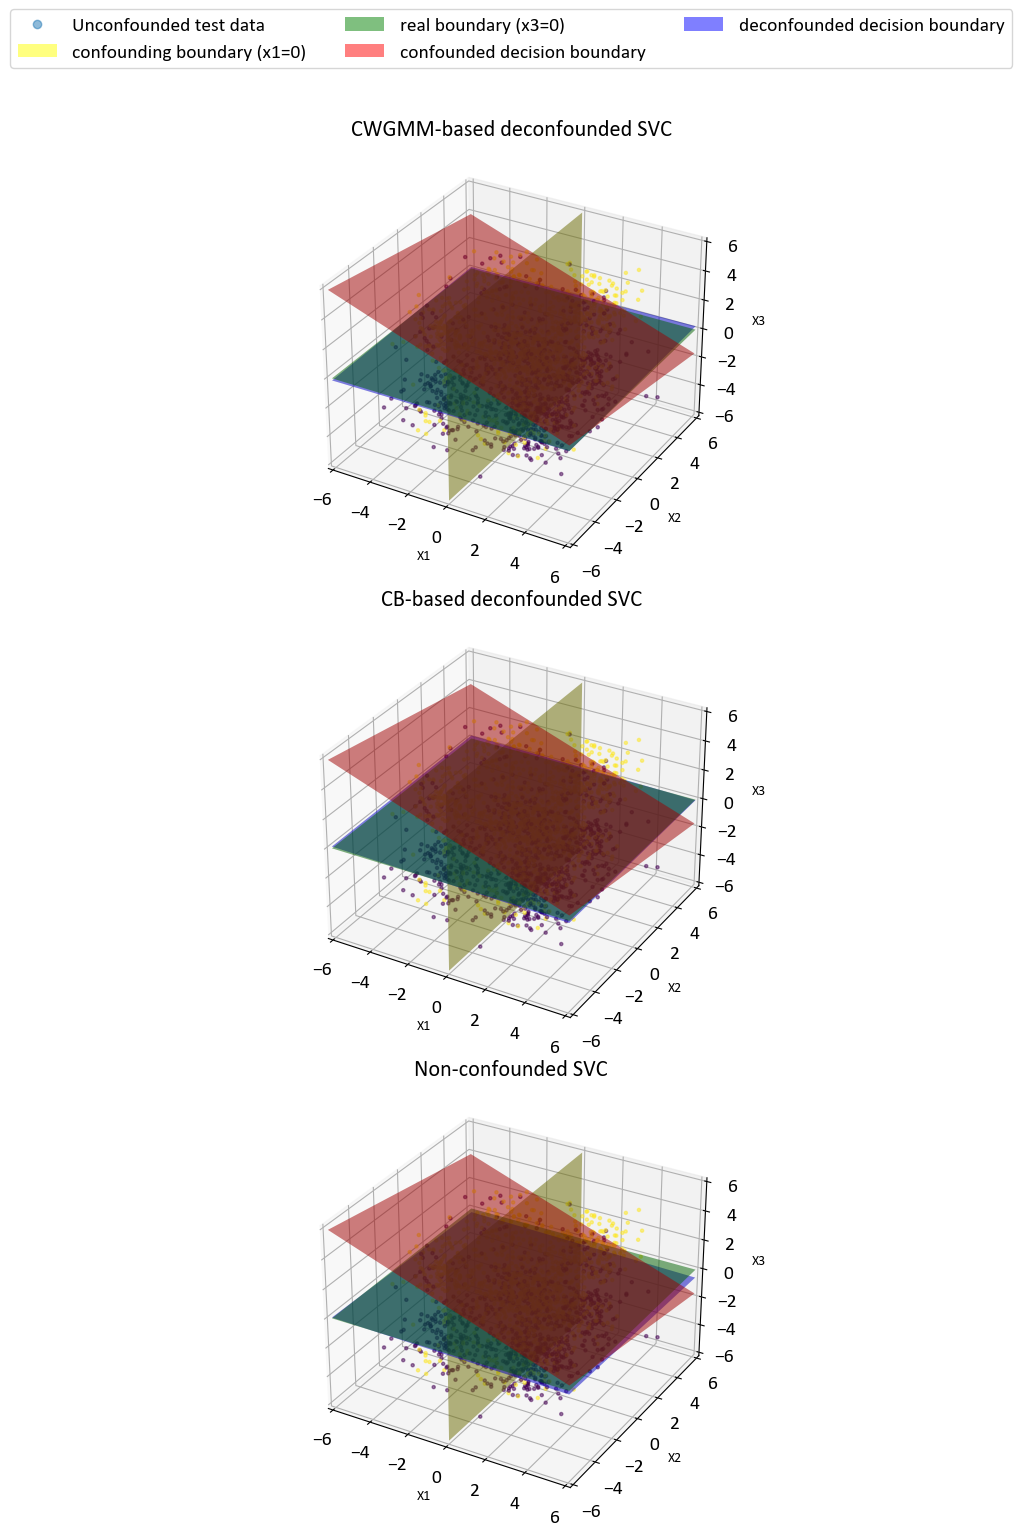

In [11]:
deconf_list = [
    ("CWGMM-based deconfounded SVC", deconf_gmm_clf),
    ("CB-based deconfounded SVC",    deconf_cb_clf),
    ("Non-confounded SVC",           nonconf_clf),
]

plot_decision_boundaries_grid(conf_clf, deconf_list, X_test_unconf, Y_test_unconf, n_row = 3, n_col = 1)